# [Steel Plate Defect Prediction](https://www.kaggle.com/competitions/playground-series-s4e3/overview)

In [5]:
import numpy as np
np.random.seed(42)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import VotingClassifier

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from collections import Counter


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore")

sns.set_theme()
sns.set_context("paper")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv
/kaggle/input/faulty-steel-plates/faults.csv


## load test data & original data

因為題目有提到這個資料集是從別的資料集的模型製作的，所以為了讓資料量變大且能夠完整運行

In [6]:
# Load the train data
train = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
train = train.set_index('id').reset_index(drop=True)

# Load the test data
test = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
test = test.set_index('id').reset_index(drop=True)

# Load the submission data
sub = pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv')

# Lod the origina df
df_org = pd.read_csv('/kaggle/input/faulty-steel-plates/faults.csv')

# Print the first few rows of each dataset
print("Train data:\n", train.shape, "\n\nTest data:\n", test.shape, "\n\nSubmission data:\n", sub.shape, "\n\nOriginal data: \n", df_org.shape)

Train data:
 (19219, 34) 

Test data:
 (12814, 27) 

Submission data:
 (12814, 8) 

Original data: 
 (1941, 34)


In [7]:
train = pd.concat([train, df_org], ignore_index=True)

In [8]:
targets = [
    'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
    'Dirtiness', 'Bumps', 'Other_Faults'
]

In [9]:
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum': These are likely the coordinates of the bounding box of the defect in the image.

'Pixels_Areas': This could represent the total number of pixels that make up the defect.

'X_Perimeter', 'Y_Perimeter': These might represent the perimeter of the defect in the X and Y directions.

'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity': These features likely relate to the brightness of the defect. The sum could be the total brightness, while the minimum and maximum could be the darkest and brightest points.

'Length_of_Conveyer': This might be a feature related to the production process, such as the length of the conveyor belt used in manufacturing.

'TypeOfSteel_A300', 'TypeOfSteel_A400': These are likely categorical features indicating the type of steel used in the plate.

'Steel_Plate_Thickness': This is likely a numerical feature indicating the thickness of the steel plate.

'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index': These indices could be related to the shape and location of the defect.

'LogOfAreas', 'Log_X_Index', 'Log_Y_Index': These features might be the logarithmic transformations of 'Pixels_Areas', 'X_Index', and 'Y_Index'.

'Orientation_Index': This could be a feature indicating the orientation of the defect.

'Luminosity_Index': This might be an index related to the brightness of the defect.

'SigmoidOfAreas': This could be a sigmoid transformation of the 'Pixels_Areas' feature.

'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults': These features might be binary or categorical, indicating the presence or absence of specific types of defects.

In [10]:
class Preprocess:
    
    def fit(self, X, y=None):
        return 
    
    def fit_transform(self, X):
        epsilon = 1e-6

        # Location Features
        X['X_Distance'] = X['X_Maximum'] - X['X_Minimum']
        X['Y_Distance'] = X['Y_Maximum'] - X['Y_Minimum']

        # Density Feature
        X['Density'] = X['Pixels_Areas'] / (X['X_Perimeter'] + X['Y_Perimeter'])

        # Relative Perimeter Feature
        X['Relative_Perimeter'] = X['X_Perimeter'] / (X['X_Perimeter'] + X['Y_Perimeter'] + epsilon)

        # Circularity Feature
        X['Circularity'] = X['Pixels_Areas'] / (X['X_Perimeter'] ** 2)

        # Symmetry Index Feature
        X['Symmetry_Index'] = np.abs(X['X_Distance'] - X['Y_Distance']) / (X['X_Distance'] + X['Y_Distance'] + epsilon)

        # Color Contrast Feature
        X['Color_Contrast'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']

        # Combined Geometric Index Feature
        X['Combined_Geometric_Index'] = X['Edges_Index'] * X['Square_Index']

        # Interaction Term Feature
        X['X_Distance*Pixels_Areas'] = X['X_Distance'] * X['Pixels_Areas']

        # Additional Features
        X['sin_orientation'] = np.sin(X['Orientation_Index'])
        X['Edges_Index2'] = np.exp(X['Edges_Index'] + epsilon)
        X['X_Maximum2'] = np.sin(X['X_Maximum'])
        X['Y_Minimum2'] = np.sin(X['Y_Minimum'])
        X['Aspect_Ratio_Pixels'] = np.where(X['Y_Perimeter'] == 0, 0, X['X_Perimeter'] / X['Y_Perimeter'])
        X['Aspect_Ratio'] = np.where(X['Y_Distance'] == 0, 0, X['X_Distance'] / X['Y_Distance'])

        # Average Luminosity Feature
        X['Average_Luminosity'] = (X['Sum_of_Luminosity'] + X['Minimum_of_Luminosity']) / 2

        # Normalized Steel Thickness Feature
        X['Normalized_Steel_Thickness'] = (X['Steel_Plate_Thickness'] - X['Steel_Plate_Thickness'].min()) / (X['Steel_Plate_Thickness'].max() - X['Steel_Plate_Thickness'].min())

        # Logarithmic Features
        X['Log_Perimeter'] = np.log(X['X_Perimeter'] + X['Y_Perimeter'] + epsilon)
        X['Log_Luminosity'] = np.log(X['Sum_of_Luminosity'] + epsilon)
        X['Log_Aspect_Ratio'] = np.log(X['Aspect_Ratio'] ** 2 + epsilon)

        # Statistical Features
        X['Combined_Index'] = X['Orientation_Index'] * X['Luminosity_Index']
        X['Sigmoid_Areas'] = 1 / (1 + np.exp(-X['LogOfAreas'] + epsilon))

        return X

train = Preprocess().fit_transform(train)
df_org = Preprocess().fit_transform(df_org)
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Y_Minimum2,Aspect_Ratio_Pixels,Aspect_Ratio,Average_Luminosity,Normalized_Steel_Thickness,Log_Perimeter,Log_Luminosity,Log_Aspect_Ratio,Combined_Index,Sigmoid_Areas
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.260085,1.600000,1.200000,1193.5,0.038462,2.564949,7.729296,0.364644,0.005200,0.769253
1,808,816,728350,728372,433,20,54,44478,70,111,...,-0.017598,0.370370,0.363636,22274.0,0.153846,4.304065,10.702750,-2.023194,-0.222347,0.933174
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.876624,1.678571,2.250000,655710.0,0.000000,7.025538,14.086599,1.621861,0.000991,0.982983
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,-0.997695,0.551724,0.296296,1658.0,0.000000,3.806663,8.071531,-2.432779,-0.026801,0.910699
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.071318,1.074627,0.444444,24156.5,1.000000,4.934474,10.783757,-1.621855,-0.224829,0.941000


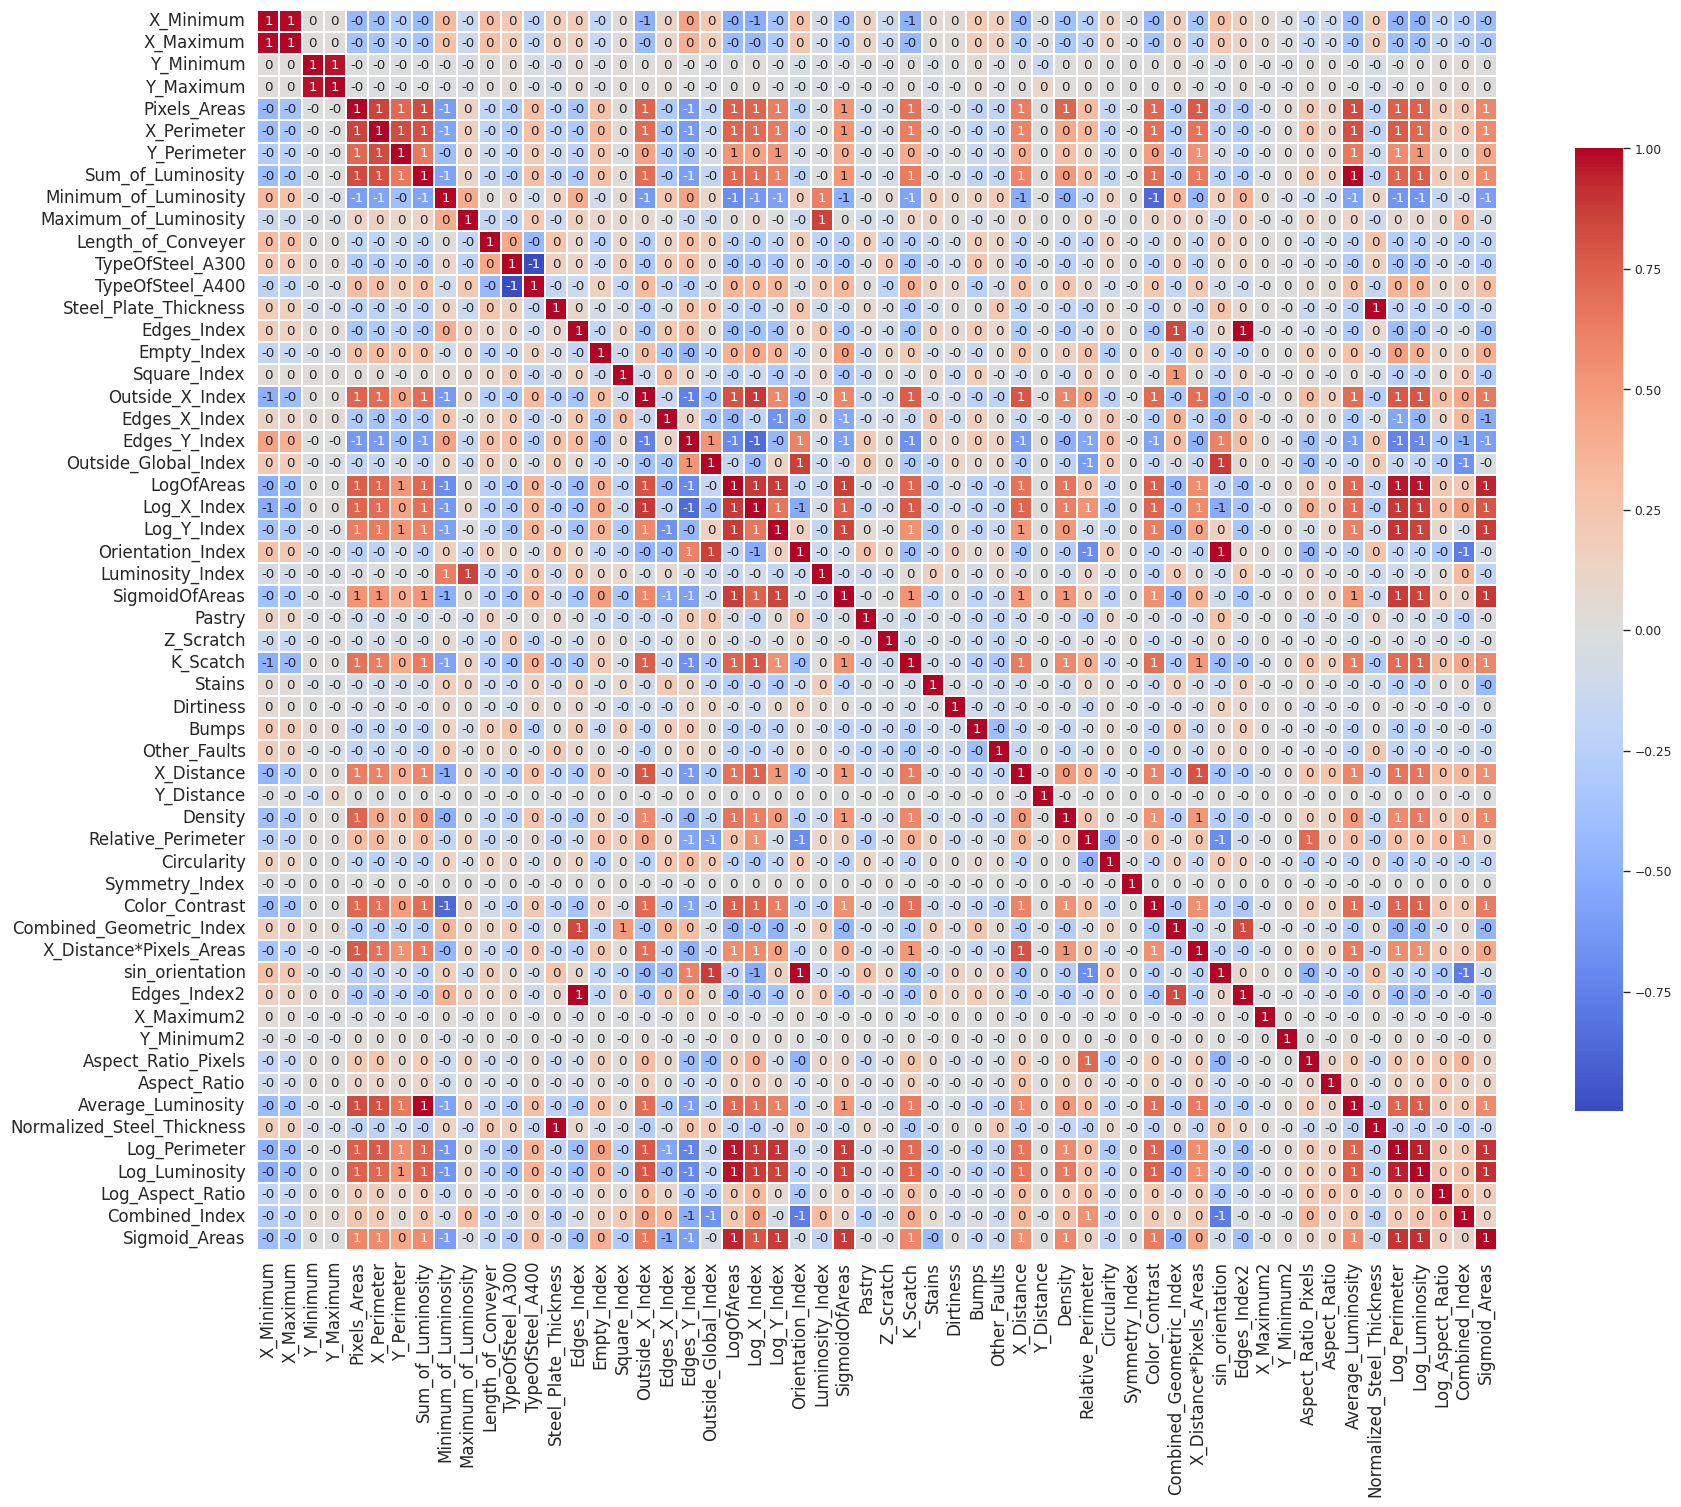

In [11]:
corr = train.corr()

f, ax = plt.subplots(figsize=(20, 25)) 

sns.heatmap(corr, annot=True, fmt=".0f", linewidths=.1, square=True, cmap='coolwarm', cbar_kws={"shrink": .5}, ax=ax)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [12]:
class FeatureSelect:
    # Initialize the FeatureSelect object with 'f' number of features to select
    def __init__(self, f):
        self.f = f

    def fit(self, X, y=None):
        return

    def fit_transform(self, X):

        X_t, y_t = X.drop(targets, axis=1), np.argmax(X[targets], axis=1)

        X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=42, stratify=y_t)
        
        #STEP 1
        
        # RFE (Recursive Feature Elimination) 
        clf = XGBClassifier(tree_method='hist', device='cuda')
        trans = RFE(clf, n_features_to_select=self.f)

        X_trans = trans.fit_transform(X_train, y_train)

        features_RFE = X_train.columns[trans.get_support()].values
        
        #STEP 2

        # RFECV (Recursive Feature Elimination with Cross-Validation)
        clf = XGBClassifier(tree_method='hist', device='cuda')
        trans = RFECV(clf)

        X_trans = trans.fit_transform(X_train, y_train)

        features_RFECV = X_train.columns[trans.get_support()].values

        #STEP 3
        
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X_train)

        all_features = X_train.columns

        # SelectKBest object with chi2 as the scoring function and 'f' as the number of features to select
        k = self.f
        chi2_selector = SelectKBest(chi2, k=k)

        X_kbest = chi2_selector.fit_transform(X_scaled, y_train)

        selected_features_indices = chi2_selector.get_support(indices=True)
        features_chi2 = [all_features[i] for i in selected_features_indices]
        
        #STEP 4

        features_RFE = list(features_RFE)
        features_RFECV = list(features_RFECV)
        features_chi2 = list(features_chi2)

        master_list = features_RFE + features_RFECV + features_chi2

        feature_counts = Counter(master_list)

        threshold = 2
        selected_features = [feature for feature, count in feature_counts.items() if count >= threshold]

        return X[selected_features+targets]

train = FeatureSelect(30).fit_transform(train)

train.head()

,X_Minimum,X_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,...,X_Distance*Pixels_Areas,Average_Luminosity,Log_Perimeter,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,584,590,16,8,5,2274,113,140,1358,0,...,96,1193.5,2.564949,0,0,0,1,0,0,0
1,808,816,433,20,54,44478,70,111,1687,1,...,3464,22274.0,4.304065,0,0,0,0,0,0,1
2,39,192,11388,705,420,1311391,29,141,1400,0,...,1742364,655710.0,7.025538,0,0,1,0,0,0,0
3,781,789,210,16,29,3202,114,134,1387,0,...,1680,1658.0,3.806663,0,0,1,0,0,0,0
4,1540,1560,521,72,67,48231,82,111,1692,0,...,10420,24156.5,4.934474,0,0,0,0,0,0,1


In [13]:
X, y = train.drop(targets, axis=1), np.argmax(train[targets], axis=1)

In [14]:
def auc_score(estimator, X, y):
    y_prob = estimator.predict_proba(X)
    return roc_auc_score(y, y_prob, multi_class="ovr")

In [15]:
xgb1_best = {'num_leaves': 68, 'learning_rate': 0.013089905386279134, 'subsample_for_bin': 140000, 'min_child_samples': 175, 'reg_alpha': 0.16355926419558364, 'reg_lambda': 0.8785092068289827, 'colsample_bytree': 0.6586646361453754, 'subsample': 0.8584577402123806, 'max_depth': 4, 'n_estimators': 900, 'boosting_type': 'dart'}

xgb2_best = {'num_leaves': 94, 'learning_rate': 0.002874597748343781, 'subsample_for_bin': 100000, 'min_child_samples': 435, 'reg_alpha': 0.5636366091953376, 'reg_lambda': 0.3942596210960868, 'colsample_bytree': 0.8838759178819496, 'subsample': 0.7693043269986217, 'max_depth': 4, 'n_estimators': 2700, 'boosting_type': 'dart'}

xgb3_best = {'num_leaves': 28, 'learning_rate': 0.017228333575766752, 'subsample_for_bin': 120000, 'min_child_samples': 90, 'reg_alpha': 0.5122794326532862, 'reg_lambda': 0.10199308808524449, 'colsample_bytree': 0.6557547364793225, 'subsample': 0.745859676358494, 'max_depth': 4, 'n_estimators': 550, 'boosting_type': 'dart'}

xgb4_best = {'num_leaves': 40, 'learning_rate': 0.008709442095331837, 'subsample_for_bin': 80000, 'min_child_samples': 85, 'reg_alpha': 0.7654886041781102, 'reg_lambda': 0.13787278396443792, 'colsample_bytree': 0.9183396023019821, 'subsample': 0.7022603517788235, 'max_depth': 4, 'n_estimators': 1050, 'boosting_type': 'gbtree'}

xgb5_best = {'num_leaves': 109, 'learning_rate': 0.011118737874685179, 'subsample_for_bin': 60000, 'min_child_samples': 245, 'reg_alpha': 0.8552840957883228, 'reg_lambda': 0.7170462291721803, 'colsample_bytree': 0.7669185803359093, 'subsample': 0.7054844703341253, 'max_depth': 3, 'n_estimators': 1550, 'boosting_type': 'gbtree'}

In [16]:
xgb1 = XGBClassifier(verbose=False, device='cuda', **xgb1_best)
xgb2 = XGBClassifier(verbose=False, device='cuda', **xgb2_best)
xgb3 = XGBClassifier(verbose=False, device='cuda', **xgb3_best)
xgb4 = XGBClassifier(verbose=False, device='cuda', **xgb4_best)
xgb5 = XGBClassifier(verbose=False, device='cuda', **xgb5_best)
xgb6 = XGBClassifier(verbose=False, device='cuda')


voting = VotingClassifier(
    estimators = [
        ('xgb1', xgb1), 
        ('xgb2', xgb2), 
        ('xgb3', xgb3), 
        ('xgb4', xgb4),
        ('xgb5', xgb5),
        ('xgb6', xgb6)
    ], 
    voting='soft')

scores = cross_val_score(voting, X, y, scoring=auc_score, cv=5)

voting.fit(X, y)

VotingClassifier(estimators=[('xgb1',
                              XGBClassifier(base_score=None, booster=None,
                                            boosting_type='dart',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6586646361453754,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            in...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [17]:
print(f'ROC AUC: {scores.mean()}')

voting

ROC AUC: 0.882432691108191


VotingClassifier(estimators=[('xgb1',
                              XGBClassifier(base_score=None, booster=None,
                                            boosting_type='dart',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6586646361453754,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            in...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [18]:
sub.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,19222,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,19223,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [19]:
test = Preprocess().fit_transform(test)

In [20]:
sub[targets] = voting.predict_proba(test[train.columns[:-7]])

In [21]:
sub.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.563822,0.001505,0.003775,0.000762,0.012776,0.134378,0.282982
1,19220,0.282638,0.016127,0.011739,0.001051,0.169530,0.174011,0.344905
2,19221,0.083376,0.036453,0.042507,0.001563,0.011697,0.356537,0.467867
3,19222,0.184349,0.002417,0.001184,0.001889,0.012406,0.421378,0.376376
4,19223,0.043220,0.002925,0.001220,0.002638,0.007086,0.561695,0.381217


In [22]:
sub.to_csv('submission.csv', index=False)